In [272]:
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

from sklearn.preprocessing import StandardScaler, RobustScaler, OneHotEncoder
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.model_selection import learning_curve
from sklearn.model_selection import cross_validate
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import GridSearchCV

from xgboost import XGBRegressor

import mlflow
import mlflow.sklearn
from urllib.parse import urlparse

In [226]:
# experiment_id = mlflow.create_experiment("xgboost_projet_appli_ia")

In [273]:
df_train_modify = pd.read_csv('../../csv/train_modifie_mickael.csv')
df_test_modify = pd.read_csv('../../csv/test_modifie_mickael.csv')

df_train = df_train_modify.drop(['Unnamed: 0', 'count','HI'], axis=1)
df_test = df_test_modify.drop(['Unnamed: 0', 'count','HI'], axis=1)

# Il FAUT éliminer ce point de données sans quoi impossible d'encoder cette variable et de réaliser une cross-validation ou un grid search cv
# df_train = df_train[df_train['weather'] != 4]

In [271]:
X_train = df_train.drop(['registered', 'casual'], axis=1)
y_train_registered = df_train['registered']
y_train_casual = df_train['casual']

X_test = df_test.drop(['registered', 'casual'], axis=1)
y_test_registered = df_test['registered']
y_test_casual = df_test['casual']

In [267]:
X_train, test, y_train_registered, test2 = train_test_split(X_train, y_train_registered, test_size=0.001)
# X_train, X_test, y_train_casual, y_test_casual = train_test_split(X_train, y_train_casual, test_size=0.2)

# Preprocessing

In [241]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, median_absolute_error

def adjustedR2(r2,n,k):
    return r2-(k-1)/(n-k)*(1-r2)

def metrics_scores(y, y_pred):
    print('MSE test : ' + str(mean_squared_error(y, y_pred)))
    print('RMSE test : ' + str(np.sqrt(mean_squared_error(y, y_pred))))
    print('MAE test : ' + str(mean_absolute_error(y, y_pred)))
    print('MdAE test : ' + str(median_absolute_error(y, y_pred)))

def metrics_scores_train(y, y_pred):
    print('MSE train : ' + str(mean_squared_error(y, y_pred)))
    print('RMSE train : ' + str(np.sqrt(mean_squared_error(y, y_pred))))
    print('MAE train : ' + str(mean_absolute_error(y, y_pred)))
    print('MdAE testraint : ' + str(median_absolute_error(y, y_pred)))

In [216]:
encoded_features = ['season', 'weather', 'week_days', 'months', 'years']
ohe = make_column_transformer((OneHotEncoder(),encoded_features), remainder='passthrough')
ohe.fit(X_train)
X_train_ohe = ohe.transform(X_train)
X_train = pd.DataFrame(X_train_ohe)

X_test_ohe = ohe.transform(X_test)
X_test = pd.DataFrame(X_test_ohe)

In [217]:
features_name = {}
for i in range(X_train.shape[1]):
    features_name[i] = ohe.get_feature_names_out()[i].replace("onehotencoder__","").replace("remainder__","")
X_train = X_train.rename(columns=features_name)
X_test = X_test.rename(columns=features_name)

In [242]:
#Features et pipelines
scaled_features = ['temp', 'atemp', 'windspeed', 'humidity', 'hours']#
scaled_pipeline = make_pipeline(StandardScaler())

#preprocessing et main pipeline
params = {'n_estimators': 105, 'max_depth': 8, 'subsample': 0.8, 'learning_rate': 0.1,
          'colsample_bytree':0.5, 'colsample_bylevel': 0.5, 'colsample_bynode': 0.4,
          'gamma': 0}
preprocessor = make_column_transformer((scaled_pipeline, scaled_features), remainder="passthrough")
xgb = XGBRegressor(n_estimators=80, max_depth=6, subsample=0.8, learning_rate=0.1, max_depth=10, learning_rate=0.15)
model = make_pipeline(preprocessor, xgb)

{'xgbregressor__colsample_bylevel': 0.5,
 'xgbregressor__colsample_bynode': 0.4,
 'xgbregressor__colsample_bytree': 0.5,
 'xgbregressor__gamma': 0,
 'xgbregressor__learning_rate': 0.1,
 'xgbregressor__max_depth': 8,
 'xgbregressor__n_estimators': 105,
 'xgbregressor__subsample': 0.9}

## Modélisation registered

In [ ]:
parameters = {'xgbregressor__n_estimators': np.arange(95,106,5),
              'xgbregressor__max_depth': np.arange(6,9,1),
              'xgbregressor__learning_rate':[0.1],
              'xgbregressor__subsample': [0.9],
              'xgbregressor__colsample_bytree': np.arange(0.4,0.6,0.1),
              'xgbregressor__colsample_bylevel': np.arange(0.4,0.6,0.1),
              'xgbregressor__colsample_bynode': np.arange(0.1,0.5,0.1),
              'xgbregressor__gamma': np.arange(0,10,5)}

grid = GridSearchCV(model, parameters,cv=5)
grid.fit(X_train, y_train_registered)

In [224]:
grid.best_params_

{'xgbregressor__colsample_bylevel': 0.5,
 'xgbregressor__colsample_bynode': 0.4,
 'xgbregressor__colsample_bytree': 0.5,
 'xgbregressor__gamma': 0,
 'xgbregressor__learning_rate': 0.1,
 'xgbregressor__max_depth': 8,
 'xgbregressor__n_estimators': 105,
 'xgbregressor__subsample': 0.9}

In [268]:
# mlflow.sklearn.autolog()

with mlflow.start_run(experiment_id = 1):

        metrics = ['r2','neg_mean_squared_error', 'neg_root_mean_squared_error', 'neg_mean_absolute_error',
                'neg_median_absolute_error']#, 'neg_mean_squared_log_error'
        scores = cross_validate(xgb,X_train,y_train_registered,cv=5,scoring=metrics)

        print(scores['test_score'])
        r2 = np.nanmean(scores['test_r2'])
        r2_adj = adjustedR2(r2,X_train.shape[0],X_train.shape[1])
        mse = np.nanmean(-scores['test_neg_mean_squared_error'])
        rmse = np.nanmean(-scores['test_neg_root_mean_squared_error'])
        mae = np.nanmean(-scores['test_neg_mean_absolute_error'])
        mdae = np.nanmean(-scores['test_neg_median_absolute_error'])
        print('r2 : ' + str(r2))
        print('r2 adj. : ' + str(r2_adj))
        print('MSE : ' + str(mse))
        print('RMSE : ' + str(rmse))
        print('MAE : ' + str(mae))
        print('MdAE : ' + str(mdae))
        print('------------------------------------------------')
        """ Valeurs par défaut : 
        - n_estimators = 1
        - max_depth = 6
        - learning_rate = 0.3
        - gamma = 0
        - subsample = 1
        - colsample_bytree,  colsample_bylevel, colsample_bynode = 1
        """
        mlflow.log_param("registered n_estimators", 1)
        mlflow.log_param("registered max_depth", 6)
        mlflow.log_param("registered learning_rate", 0.3)
        mlflow.log_param("registered gamma", 0)
        mlflow.log_param("registered subsample", 1)
        mlflow.log_param("registered colsample_bylevel", 1)
        mlflow.log_param("registered colsample_bynode", 1)
        mlflow.log_param("registered colsample_bytree", 1)

        mlflow.log_metric("registered r2", r2)
        mlflow.log_metric("registered r2 adj.", r2_adj)
        mlflow.log_metric("registered MSE", mse)
        mlflow.log_metric("registered RMSE", rmse)
        mlflow.log_metric("registered MAE", mae) 
        mlflow.log_metric("registered MdAE", mdae) 

        # r2 = model.score(X_test, y_test_registered)
        # y_pred_registered = model.predict(X_test)
        # print('r2 : ' + str(r2))
        # print('r2 adj. : ' + str(adjustedR2(r2,X_train.shape[0],X_train.shape[1])))
        # metrics_scores(y_test_registered,y_pred_registered)

C:\Anaconda\envs\mv\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Anaconda\envs\mv\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Anaconda\envs\mv\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Anaconda\envs\mv\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas

[0.92284956 0.91337951 0.92478844 0.92178838 0.9201005 ]


In [194]:
N, train_score, val_score = learning_curve(model, X_train, y_train_registered, train_sizes=np.linspace(0.1,1,20))

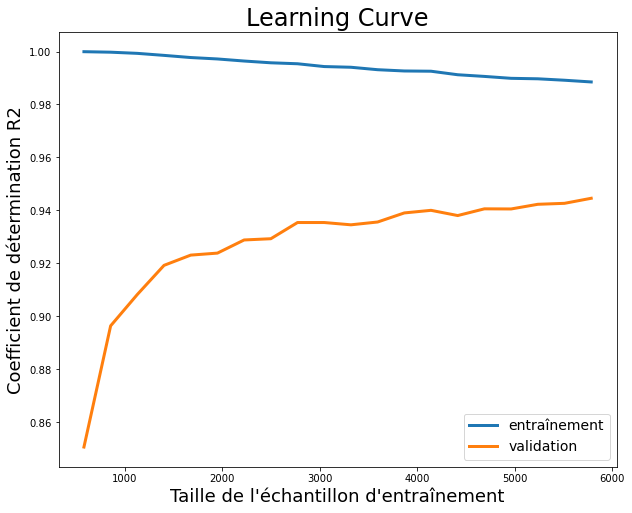

In [195]:
plt.figure(figsize=(10,8))
plt.plot(N,train_score.mean(axis=1),lw=3,label='entraînement')
plt.plot(N,np.nanmean(val_score,axis=1),lw=3,label='validation')
plt.title('Learning Curve',fontsize=24)
plt.xlabel('Taille de l\'échantillon d\'entraînement',fontsize=18)
plt.ylabel('Coefficient de détermination R2',fontsize=18)
plt.legend(fontsize=14)

## Modélisation casual

In [ ]:
with mlflow.start_run(experiment_id = 1):

    metrics = ['r2','neg_mean_squared_error', 'neg_root_mean_squared_error', 'neg_mean_absolute_error','neg_median_absolute_error']
    scores = cross_validate(model,X_train,y_train_casual,cv=5,scoring=metrics)

    print(scores['test_r2'])
    r2 = np.nanmean(scores['test_r2'])
    print('r2 : ' + str(r2))
    print('r2 adj. : ' + str(adjustedR2(r2,X_train.shape[0],X_train.shape[1])))
    print('MSE : ' + str(np.nanmean(-scores['test_neg_mean_squared_error'])))
    print('RMSE : ' + str(np.nanmean(-scores['test_neg_root_mean_squared_error'])))
    print('MAE : ' + str(np.nanmean(-scores['test_neg_mean_absolute_error'])))
    print('MdAE : ' + str(np.nanmean(-scores['test_neg_median_absolute_error'])))
    # print('------------------------------------------------')
    """ Valeurs par défaut : 
        - n_estimators = 1
        - max_depth = 6
        - learning_rate = 0.3
        - gamma = 0
        - subsample = 1
        - colsample_bytree,  colsample_bylevel, colsample_bynode = 1
    """
    mlflow.log_param("casual n_estimators", 1)
    mlflow.log_param("casual max_depth", 6)
    mlflow.log_param("casual learning_rate", 0.3)
    mlflow.log_param("casual gamma", 0)
    mlflow.log_param("casual subsample", 1)
    mlflow.log_param("casual colsample_bylevel", 1)
    mlflow.log_param("casual colsample_bynode", 1)
    mlflow.log_param("casual colsample_bytree", 1)

    mlflow.log_metric("casual r2", r2)
    mlflow.log_metric("casual r2 adj.", r2_adj)
    mlflow.log_metric("casual MSE", mse)
    mlflow.log_metric("casual RMSE", rmse)
    mlflow.log_metric("casual MAE", mae) 
    mlflow.log_metric("casual MdAE", mdae) 

    # r2 = model.score(X_test, y_test_casual)

    # print('r2 : ' + str(r2))
    # print('r2 adj. : ' + str(adjustedR2(r2,X_train.shape[0],X_train.shape[1])))
    # metrics_scores(y_test_casual,y_pred_casual)
    # residus_test = y_pred-y_train_casual
    # y_pred_casual = model.predict(X_test)

[0.86848475 0.85967982 0.88080898 0.87786016 0.86088723]
r2 : 0.8695441897084155
r2 adj. : 0.8693182139414112
MSE : 2565.041673844508
RMSE : 50.60357054145378
MAE : 32.817744156003606
MdAE : 18.732975006103516
